In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

import xarray as xr

from typing import Sequence, Optional, Union

import torch
import tqdm
from torch import nn
from torch import optim
from torch.distributions import Normal

from collections import namedtuple

import torchsde

#for plotting
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


import numpy as np
import scipy as scp
import scipy.stats as ss
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from mpl_toolkits import mplot3d
from matplotlib import cm
import scipy.special as scsp
from scipy.integrate import quad
from scipy.interpolate import RegularGridInterpolator


from datetime import date
import holidays


from sys import exit

In [3]:
from torchdyn.utils import plot_3D_dataset
from torchdyn.datasets import ToyDataset
from torch.utils.data import TensorDataset, DataLoader

In [4]:
device = torch.device("cpu")
dry_run = False

In [11]:
d = ToyDataset()
X, yn = d.generate(n_samples=512, dataset_type='moons', noise=.4)
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = TensorDataset(X_train, y_train)
trainloader = DataLoader(train, batch_size=len(X), shuffle=False)

t_span = torch.linspace(0, 1, 2)

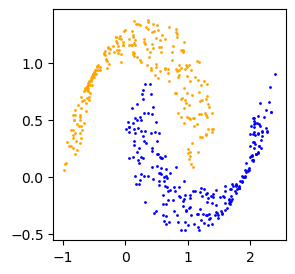

In [6]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], s=1, color=colors[yn[i].int()])

In [19]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        t_eval, y_hat = self.model(x, t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [20]:
from torchdyn.core import NeuralSDE

In [21]:
import torchsde

t_span = torch.linspace(0, 0.1, 100).to(device)
size = X.shape

bm = torchsde.BrownianInterval(
    t0=t_span[0],
    t1=t_span[-1],
    size=size,
    device=device,
    levy_area_approximation='space-time'
)

In [23]:
f = nn.Sequential(nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 2))
g = nn.Sequential(nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 2))


model = NeuralSDE(f, 
                  g,
                  solver='euler',
                  noise_type='diagonal',
                  sde_type='ito',
                  sensitivity='autograd',
                  bm=bm
                 ).to(device)

NameError: name 'torchdyn' is not defined